# Language Translation using OCR

You can create many interesting and useful computer vision application once you know how to perform Text Detection and Recognition on images. We will build a simple but useful application that allows you to translate text from one language to a language of your choice. This is particularly useful for tourists going to a country where the local language is very different from their country. Just take a picture of the text you don't understand and the app would tell you what's written!

For the language translation part, we will be using a library called [**googletrans**](https://pypi.org/project/googletrans/) (specifically v4), which uses the Google Translate API under the hood. The **`googletrans`** supports automatic detection of input language and translation to multiple languages.

## 1. Prepare

In [1]:
# Install google translate library
!pip install googletrans==4.0.0-rc1
!pip install pyttsx3

In [2]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import googletrans

## 2. Google Translator Python API

In [3]:
# Check language support
print(googletrans.LANGUAGES)

{'af': 'afrikaans', 'sq': 'albanian', 'am': 'amharic', 'ar': 'arabic', 'hy': 'armenian', 'az': 'azerbaijani', 'eu': 'basque', 'be': 'belarusian', 'bn': 'bengali', 'bs': 'bosnian', 'bg': 'bulgarian', 'ca': 'catalan', 'ceb': 'cebuano', 'ny': 'chichewa', 'zh-cn': 'chinese (simplified)', 'zh-tw': 'chinese (traditional)', 'co': 'corsican', 'hr': 'croatian', 'cs': 'czech', 'da': 'danish', 'nl': 'dutch', 'en': 'english', 'eo': 'esperanto', 'et': 'estonian', 'tl': 'filipino', 'fi': 'finnish', 'fr': 'french', 'fy': 'frisian', 'gl': 'galician', 'ka': 'georgian', 'de': 'german', 'el': 'greek', 'gu': 'gujarati', 'ht': 'haitian creole', 'ha': 'hausa', 'haw': 'hawaiian', 'iw': 'hebrew', 'he': 'hebrew', 'hi': 'hindi', 'hmn': 'hmong', 'hu': 'hungarian', 'is': 'icelandic', 'ig': 'igbo', 'id': 'indonesian', 'ga': 'irish', 'it': 'italian', 'ja': 'japanese', 'jw': 'javanese', 'kn': 'kannada', 'kk': 'kazakh', 'km': 'khmer', 'ko': 'korean', 'ku': 'kurdish (kurmanji)', 'ky': 'kyrgyz', 'lo': 'lao', 'la': 'lat

In [4]:
# Create translator object
translator = googletrans.Translator()

In [5]:
# Automatic detection of language
translator.detect('maison').lang

'fr'

In [6]:
# Translation example
result = translator.translate('maison', dest='en')
print(result.text)

House


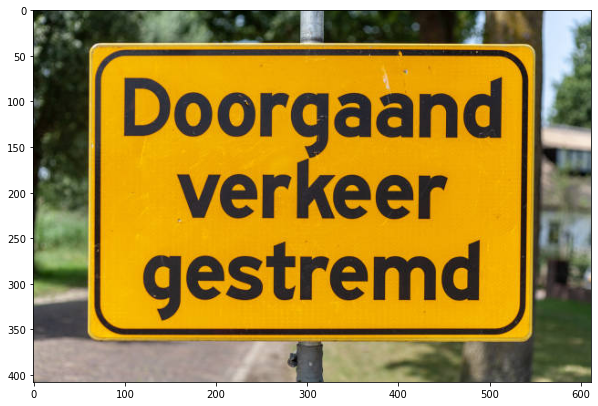

In [7]:
image = cv2.imread('../visuals/dutch_signboard.jpg')
plt.figure(figsize=(10,8))
plt.imshow(image[:,:,::-1])

In [8]:
# Define list to store the vocabulary in.
vocabulary =[]

# Open file to import the vocabulary.
with open("./alphabet_94.txt") as f:
    # Read the file line by line, and append each into the vocabulary list.
    for line in f:
        vocabulary.append(line.strip())
    f.close()

## 3. Import the text detection and recognition model

### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>

For the text detection in the image, we will be using the DB based text detection deep learning neural network model covered in the previous notebook. 

[**`DB Text Detection Model()`**](https://docs.opencv.org/master/db/d0f/classcv_1_1dnn_1_1TextDetectionModel__DB.html)

In [9]:
# DB model for text-detection based on resnet50
textDetector = cv2.dnn_TextDetectionModel_DB('../resources/DB_TD500_resnet50.onnx')
inputSize = (640,640)

# Set threshold for binary map creation and polygon detection
binThresh = 0.3
polyThresh = 0.5

mean = (122.67891434, 116.66876762, 104.00698793)

textDetector.setBinaryThreshold(binThresh).setPolygonThreshold(polyThresh)
textDetector.setInputParams(1.0/255, inputSize, mean, True)


For the text recognizer we will be using a CRNN based deep learning model that is trained on 2 datasets: 

* MJsynth and 
* SynthText

It can identify all characters along with punctuations. Thus, there are 94 characters in the alphabet.

[**`Text Recognition Model()`**](https://docs.opencv.org/4.5.2/de/dee/classcv_1_1dnn_1_1TextRecognitionModel.html)

In [10]:
# CRNN model for text-recognition
textRecognizer = cv2.dnn_TextRecognitionModel('../resources/crnn_cs.onnx')
textRecognizer.setDecodeType('CTC-greedy')
textRecognizer.setVocabulary(vocabulary)

textRecognizer.setInputParams(1/127.5, (100,32), (127.5, 127.5, 127.5), True)

## 4. Align text boxes

Geometric image transformation functions are used to align the text boxes horizontally by applying perspective transform on the roi boxes detected by the DB text detector. This will help the text recognizer to identify the characters better.

[**`Geometric Image Transforms()`**](https://docs.opencv.org/4.5.2/da/d54/group__imgproc__transform.html)

In [11]:
def fourPointsTransform(frame, vertices):
    # Print vertices of each bounding box
    vertices = np.asarray(vertices).astype(np.float32)
    outputSize = (100, 32)
    targetVertices = np.array([
        [0, outputSize[1] - 1],
        [0, 0],
        [outputSize[0] - 1, 0],
        [outputSize[0] - 1, outputSize[1] - 1]], dtype='float32')
    
    # Apply perspective transform
    rotationMatrix = cv2.getPerspectiveTransform(vertices, targetVertices)
    result = cv2.warpPerspective(frame, rotationMatrix, outputSize)
    return result

## 5. Perform language translation on recognized text

In [12]:
def recognizeTranslateText(image, dest='en', src='', debug=False):
    # Create a blank matrix to be used to display the output image
    outputCanvas = np.full(image.shape[:3], 255, dtype=np.uint8)
    
    # Use the DB text detector initialized previously to detect the presence of the text in the image
    boxes, confs = textDetector.detect(image)
    
    # Iterate through the bounding boxex detected 
    for box in boxes:
        # Apply transformation 
        croppedRoi = fourPointsTransform(image, box)
        if debug:
            plt.imshow(croppedRoi)
            plt.show()
            
        # Recognize text using the crnn model
        recognizedText = textRecognizer.recognize(croppedRoi)
        print('Recognized Text: ' + recognizedText)
        
        # Perform translate
        translation = translator.translate(recognizedText, dest) 
        print('Translated Text: ' + translation.text + '\n')
        
        # Get scaled values
        boxHeight = int((abs((box[0,1] - box[1,1]))))
        
        # Get scale of the font
        fontScale = cv2.getFontScaleFromHeight(
            cv2.FONT_HERSHEY_SIMPLEX, boxHeight - 5, 1)
        
        # Write the recognized text on the output image
        placement = (int(box[0, 0]), int(box[0, 1]))
        cv2.putText(outputCanvas, translation.text, placement,
            cv2.FONT_HERSHEY_SIMPLEX, fontScale, (255,0,0), 5, 5)
        
    # Draw the bounding boxes of text detected
    cv2.polylines(image, boxes, True, (255, 0, 255), 3)
    
    # Concatenate the input image with the output image
    combineResult = cv2.hconcat([image, outputCanvas])
    
    # Display the output image
    plt.figure(figsize=[20,10])
    plt.imshow(combineResult[:,:,::-1])
    plt.title('Translation Output')

## 6. Output Sample

Recognized Text: LIBERTE
Translated Text: FREEDOM



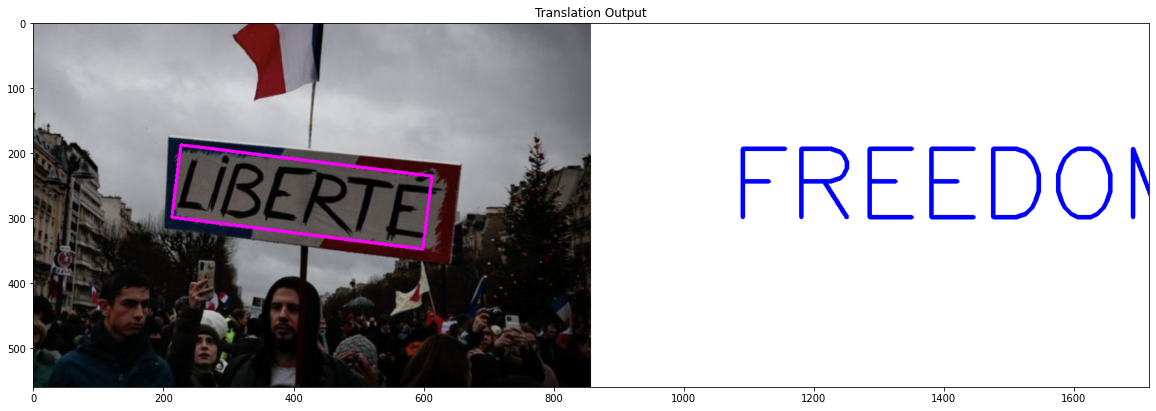

In [13]:
image = cv2.imread('../visuals/input_1.png')
recognizeTranslateText(image)

Recognized Text: ARRET
Translated Text: STOP



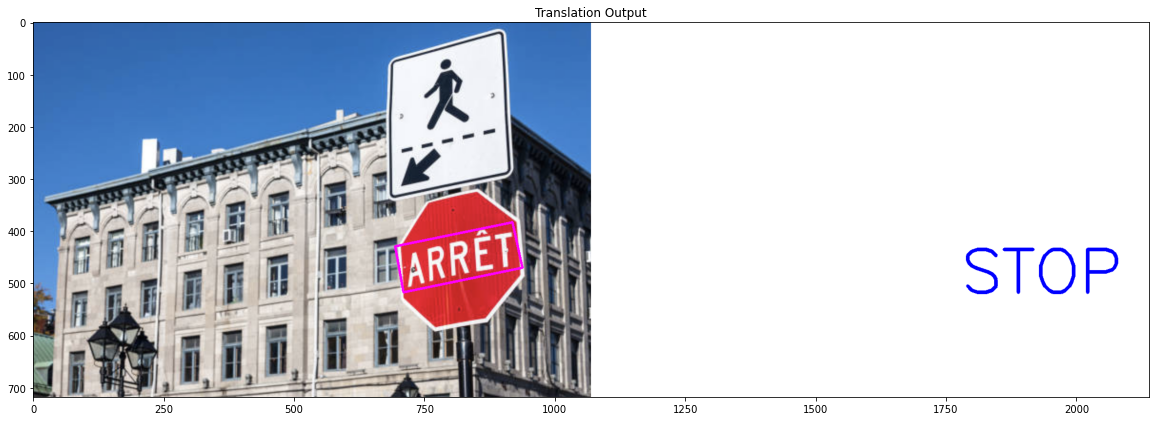

In [14]:
image = cv2.imread('../visuals/input_2.png')
recognizeTranslateText(image)

Recognized Text: DerBirgermeister
Translated Text: Abirgermeister

Recognized Text: StadtFalkensee
Translated Text: City folkensee

Recognized Text: verboten
Translated Text: forbidden

Recognized Text: Betreton
Translated Text: Intrusion

Recognized Text: Eisflache
Translated Text: Ice flat



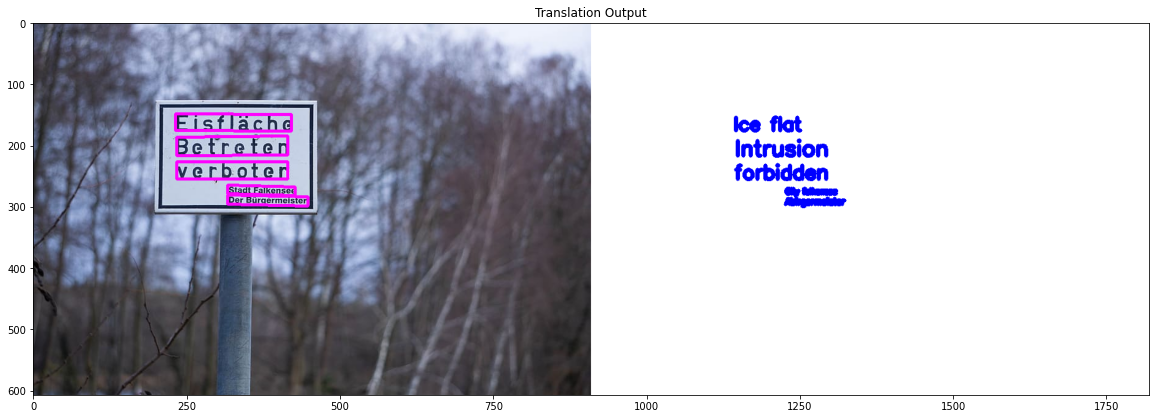

In [15]:
# Load Image.
image = cv2.imread('../visuals/german_sign.jpg')
recognizeTranslateText(image, src='de')